In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData, events_from_scdinfo
from fvt_classifier import FvTClassifier
from plots import calibration_plot
from tst_info import TSTInfo


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

# Temperature Scaling: not working well

In [2]:
import numpy as np
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import matplotlib.pyplot as plt

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seed = 0

hparams_filter = {
    "n_3b": n_3b,
    "signal_ratio": 0.00,
    "experiment_name": experiment_name,
    "seed": seed,
}
hashes = TSTInfo.find(hparams_filter)
tst_hash = hashes[0]

tst_info = TSTInfo.load(tst_hash)
events_tst = events_from_scdinfo(tst_info.scdinfo_tst, features, signal_filename)

base_fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{tst_info.base_fvt_tinfo_hash}_best.ckpt")
base_fvt_model.freeze()
base_fvt_model.to(device)
print()

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# calibration through temperature scaling

np.random.seed(seed)
calib_idx = np.random.choice(len(events_tst), size=len(events_tst)//2, replace=False)
calib_idx = np.isin(np.arange(len(events_tst)), calib_idx)
events_calibration = events_tst[calib_idx]
events_other = events_tst[~calib_idx]

logits = base_fvt_model(events_calibration.X_torch.to(device)).requires_grad_(False)
labels = events_calibration.is_4b_torch.to(device).requires_grad_(False)
weights = events_calibration.weights_torch.to(device).requires_grad_(False)

# temperature scaling
t_log_scale = nn.Parameter(torch.tensor(0.0), requires_grad=True)
t_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

optimizer = optim.Adam([t_log_scale, t_bias], lr=1e-1)

# initialize temperature scaling parameters randomly
t_log_scale.data = torch.randn(1).to(device)
t_bias.data = torch.randn(1).to(device)


def temperature_scaling(logits, t_log_scale, t_bias):
    new_logits = logits * torch.exp(t_log_scale)
    new_logits[:, 1] += t_bias
    return new_logits

def loss_fn(logits, labels, weights):
    losses = F.cross_entropy(logits, labels, reduction="none") * weights
    return losses.sum() / weights.sum()

(logits_train, logits_val, 
 labels_train, labels_val, 
 weights_train, weights_val) = train_test_split(logits, labels, weights, test_size=1/3, random_state=42)

train_loader = DataLoader(list(zip(logits_train, labels_train, weights_train)), batch_size=1024, shuffle=True)
val_loader = DataLoader(list(zip(logits_val, labels_val, weights_val)), batch_size=1024, shuffle=False)

best_val_loss = float('inf')

for epoch in tqdm(range(30)):
    with torch.no_grad():
        logits_val_scaled = temperature_scaling(logits_val, t_log_scale, t_bias)
        loss_val = loss_fn(logits_val_scaled, labels_val, weights_val)
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            best_t_log_scale = t_log_scale.item()
            best_t_bias = t_bias.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Validation Loss: {loss_val.item():.4f}, Best Validation Loss: {best_val_loss.item():.4f}")
            print(f"Parameters: t_log_scale: {t_log_scale.item():.4f}, t_bias: {t_bias.item():.4f}")
            
    for logits, labels, weights in train_loader:
        logits = logits.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        optimizer.zero_grad()
        logits_scaled = temperature_scaling(logits, t_log_scale, t_bias)
        loss = loss_fn(logits_scaled, labels, weights)
        loss.backward()
        optimizer.step()
        

print(f"Best Validation Loss: {best_val_loss.item():.4f}")
print(f"Best Parameters: t_log_scale: {best_t_log_scale:.4f}, t_bias: {best_t_bias:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0, Validation Loss: 1.2469, Best Validation Loss: 1.2469
Parameters: t_log_scale: 1.3074, t_bias: -2.6610


 33%|███▎      | 10/30 [00:04<00:09,  2.07it/s]

Epoch 10, Validation Loss: 0.6586, Best Validation Loss: 0.6582
Parameters: t_log_scale: -0.0428, t_bias: -0.0524


 67%|██████▋   | 20/30 [00:10<00:05,  1.93it/s]

Epoch 20, Validation Loss: 0.6583, Best Validation Loss: 0.6582
Parameters: t_log_scale: 0.1202, t_bias: -0.0255


100%|██████████| 30/30 [00:15<00:00,  1.99it/s]

Best Validation Loss: 0.6582
Best Parameters: t_log_scale: 0.0634, t_bias: -0.0071


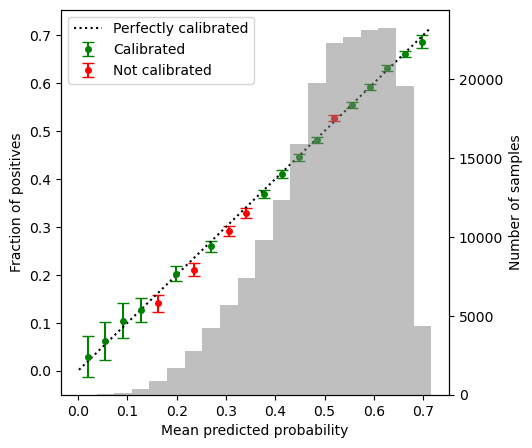

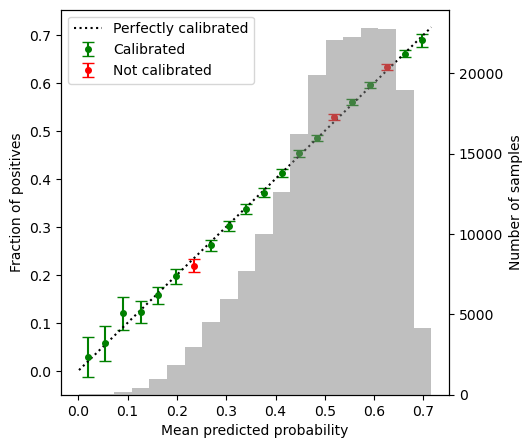

In [4]:
from plots import calibration_plot
probs_test_original = base_fvt_model.predict(events_other.X_torch.to(device))[:, 1].detach().cpu().numpy()
calibration_plot(probs_test_original, events_other.is_4b, bins=20, sample_weights=events_other.weights)
plt.show()

# Apply temperature scaling to the test set
logits_test = base_fvt_model(events_other.X_torch.to(device))
logits_test_scaled = temperature_scaling(logits_test, t_log_scale, t_bias)        

# Calculate the probabilities
probs_test = F.softmax(logits_test_scaled, dim=1)[:, 1].detach().cpu().numpy()
calibration_plot(probs_test, events_other.is_4b, bins=20, sample_weights=events_other.weights)
plt.show()

# Calibration via Isotonic Regression

In [31]:
from sklearn.isotonic import IsotonicRegression


n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seed = 10

hparams_filter = {
    "n_3b": n_3b,
    "signal_ratio": 0.00,
    "experiment_name": experiment_name,
    "seed": seed,
}
hashes = TSTInfo.find(hparams_filter)
tst_hash = hashes[0]

tst_info = TSTInfo.load(tst_hash)
events_tst = events_from_scdinfo(tst_info.scdinfo_tst, features, signal_filename)
CR_cut = tst_info.CR_cut
SR_cut = tst_info.SR_cut
SR_stat = tst_info.SR_stats
in_SR = SR_stat >= SR_cut
in_CR = (SR_stat < SR_cut) & (SR_stat >= CR_cut)

CR_fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{tst_info.CR_fvt_tinfo_hash}_best.ckpt")
CR_fvt_model.freeze()
CR_fvt_model.to(device)

events_CR = events_tst[in_CR]
events_SR = events_tst[in_SR]

events_CR.set_model_scores(CR_fvt_model)
events_SR.set_model_scores(CR_fvt_model)

Ensemble 1 / 5
Ensemble 2 / 5
Ensemble 3 / 5
Ensemble 4 / 5
Ensemble 5 / 5


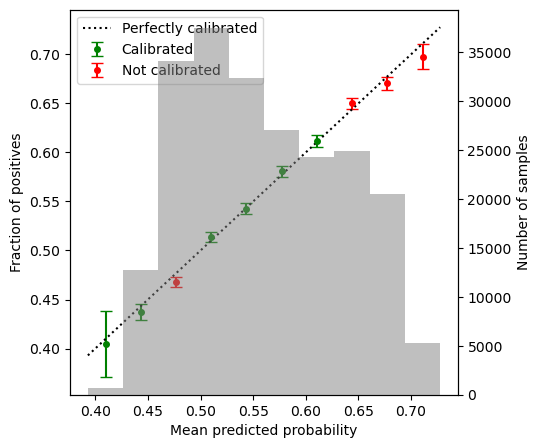

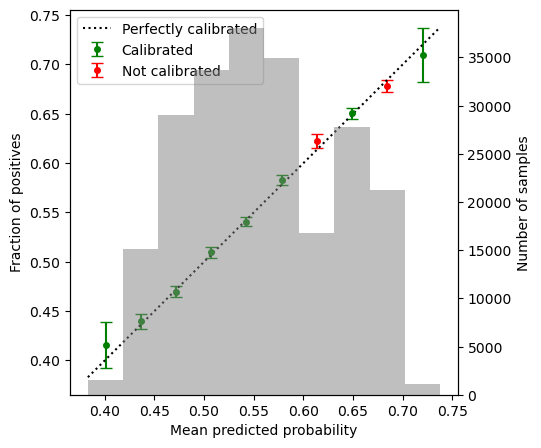

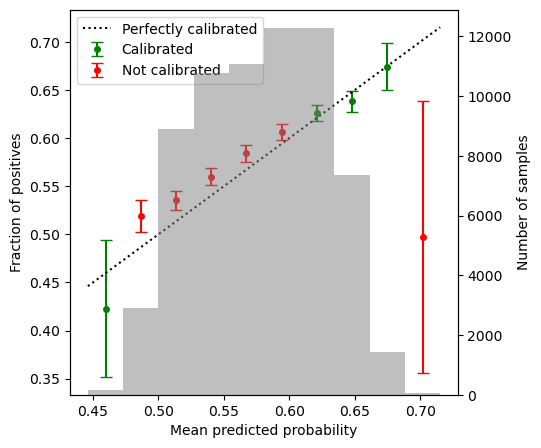

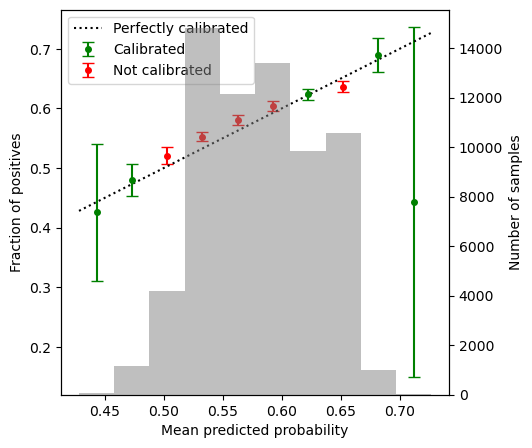

In [32]:
probs_CR_orig = CR_fvt_model.predict(events_CR.X_torch.to(device))[:, 1].detach().cpu().numpy()
y_margin = 1e-2
y_min = max(1e-5, np.min(probs_CR_orig) - y_margin)
y_max = min(1 - 1e-5, np.max(probs_CR_orig) + y_margin)


n_ensemble = 5
isotonic_reg_list = []
for i in range(n_ensemble):
    print(f"Ensemble {i+1} / {n_ensemble}")
    ensemble_events = events_CR.poisson_sample(len(events_CR) // n_ensemble)
    isotonic_reg = IsotonicRegression(y_min=y_min, y_max=y_max, out_of_bounds='clip')
    isotonic_reg.fit(ensemble_events.fvt_score, 
                     ensemble_events.is_4b)
                    #  sample_weight=ensemble_events.weights)
    isotonic_reg_list.append(isotonic_reg)

probs_CR_isotonic = np.zeros_like(probs_CR_orig)
for isotonic_reg in isotonic_reg_list:
    probs_CR_isotonic += isotonic_reg.transform(probs_CR_orig)
probs_CR_isotonic /= n_ensemble

calibration_plot(probs_CR_orig, events_CR.is_4b, bins=10, sample_weights=events_CR.weights)
plt.show()

calibration_plot(probs_CR_isotonic, events_CR.is_4b, bins=10, sample_weights=events_CR.weights)
plt.show()

probs_SR_orig = CR_fvt_model.predict(events_SR.X_torch.to(device))[:, 1].detach().cpu().numpy()
probs_SR_isotonic = np.zeros_like(probs_SR_orig)
for isotonic_reg in isotonic_reg_list:
    probs_SR_isotonic += isotonic_reg.transform(probs_SR_orig)
probs_SR_isotonic /= n_ensemble
calibration_plot(probs_SR_orig, events_SR.is_4b, bins=10, sample_weights=events_SR.weights)
plt.show()

calibration_plot(probs_SR_isotonic, events_SR.is_4b, bins=10, sample_weights=events_SR.weights)
plt.show()

In [33]:
# cross entropy before and after calibration

ce_CR_orig = -np.log(np.where(events_CR.is_4b, probs_CR_orig, 1 - probs_CR_orig)) * events_CR.weights
ce_CR_calib = -np.log(np.where(events_CR.is_4b, probs_CR_isotonic, 1 - probs_CR_isotonic)) * events_CR.weights

print(f"Cross entropy before calibration: {ce_CR_orig.sum() / events_CR.weights.sum():.4f}")
print(f"Cross entropy after calibration: {ce_CR_calib.sum() / events_CR.weights.sum():.4f}")

ce_SR_orig = -np.log(np.where(events_SR.is_4b, probs_SR_orig, 1 - probs_SR_orig)) * events_SR.weights
ce_SR_calib = -np.log(np.where(events_SR.is_4b, probs_SR_isotonic, 1 - probs_SR_isotonic)) * events_SR.weights

print(f"Cross entropy before calibration: {ce_SR_orig.sum() / events_SR.weights.sum():.4f}")
print(f"Cross entropy after calibration: {ce_SR_calib.sum() / events_SR.weights.sum():.4f}")

Cross entropy before calibration: 0.6752
Cross entropy after calibration: 0.6751
Cross entropy before calibration: 0.6743
Cross entropy after calibration: 0.6744


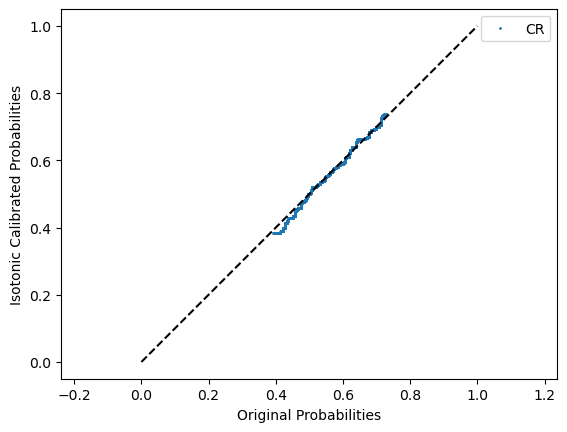

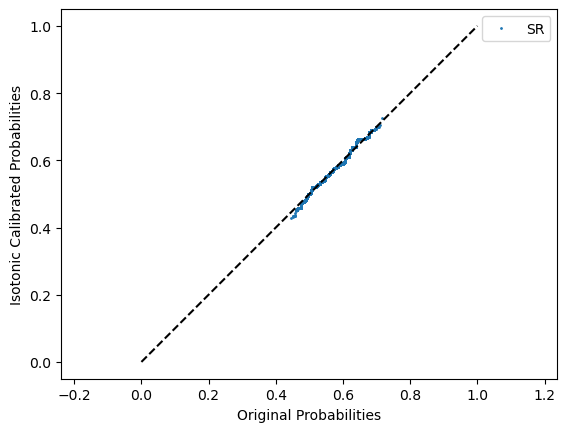

In [34]:
plt.rcParams["lines.markersize"] = 1
plt.plot(probs_CR_orig, probs_CR_isotonic, "o", label="CR")
plt.axis("equal")
plt.xlabel("Original Probabilities")
plt.ylabel("Isotonic Calibrated Probabilities")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.legend()
plt.show()

plt.rcParams["lines.markersize"] = 1
plt.plot(probs_SR_orig, probs_SR_isotonic, "o", label="SR")
plt.axis("equal")
plt.xlabel("Original Probabilities")
plt.ylabel("Isotonic Calibrated Probabilities")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.legend()
plt.show()



In [35]:
from debiasing import get_histograms

def plot_yeah(ax1, ax2, events_orig, x_values, reweights, nbins:int, bin_mode:str):
    events = events_orig.clone()
    events.reweight(
        np.where(events.is_4b, events.weights, events.weights * reweights)
    )
    if bin_mode == "quantile":
        q = np.linspace(0, 1, nbins + 1)
        bins = np.quantile(x_values, q)
    elif bin_mode == "uniform":
        bins = np.linspace(x_values.min(), x_values.max(), nbins + 1)
    else:
        raise ValueError(f"Invalid bin mode: {bin_mode}")
    
    hist_events_by_labels(events, x_values, bins, ax1)
    ax1.legend()

    histograms = get_histograms(events, x_values, bins, reweights)
    hist_3b = histograms["3b"]
    hist_3b_rwsq = histograms["3b_rw_sq"]
    hist_bg4b = histograms["bg4b"]

    ylim = (0.8, 1.2)
    ax2.errorbar((bins[1:] + bins[:-1]) / 2, 
                hist_bg4b / hist_3b, 
                yerr=np.sqrt(hist_bg4b + hist_3b_rwsq) / hist_3b,
                fmt="o", markersize=3, label="4b / 3b", capsize=3)
    ax2.set_ylim(ylim)
    ax2.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
    ymin, ymax = ax2.get_ylim()
    ax2.vlines(bins[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)
    ax2.set_ylabel("True 4b / Modeled 4b")
    ax2.legend()
    
    sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b + hist_3b_rwsq)
    sigma_avg = np.sqrt((sigma**2).mean())
    midpoints = (bins[1:] + bins[:-1]) / 2
    ax2_2 = ax2.twinx()
    ax2_2.set_ylim(-4, 4)
    ax2_2.plot(midpoints, sigma, "o", markersize=3, label="sigma", color="red")
    ax2_2.set_ylabel("sigma")
    ax2_2.legend()
    ax2_2.set_title(f"sigma_avg = {sigma_avg:.4f}")

1.3530350347746043
Calibrated: True


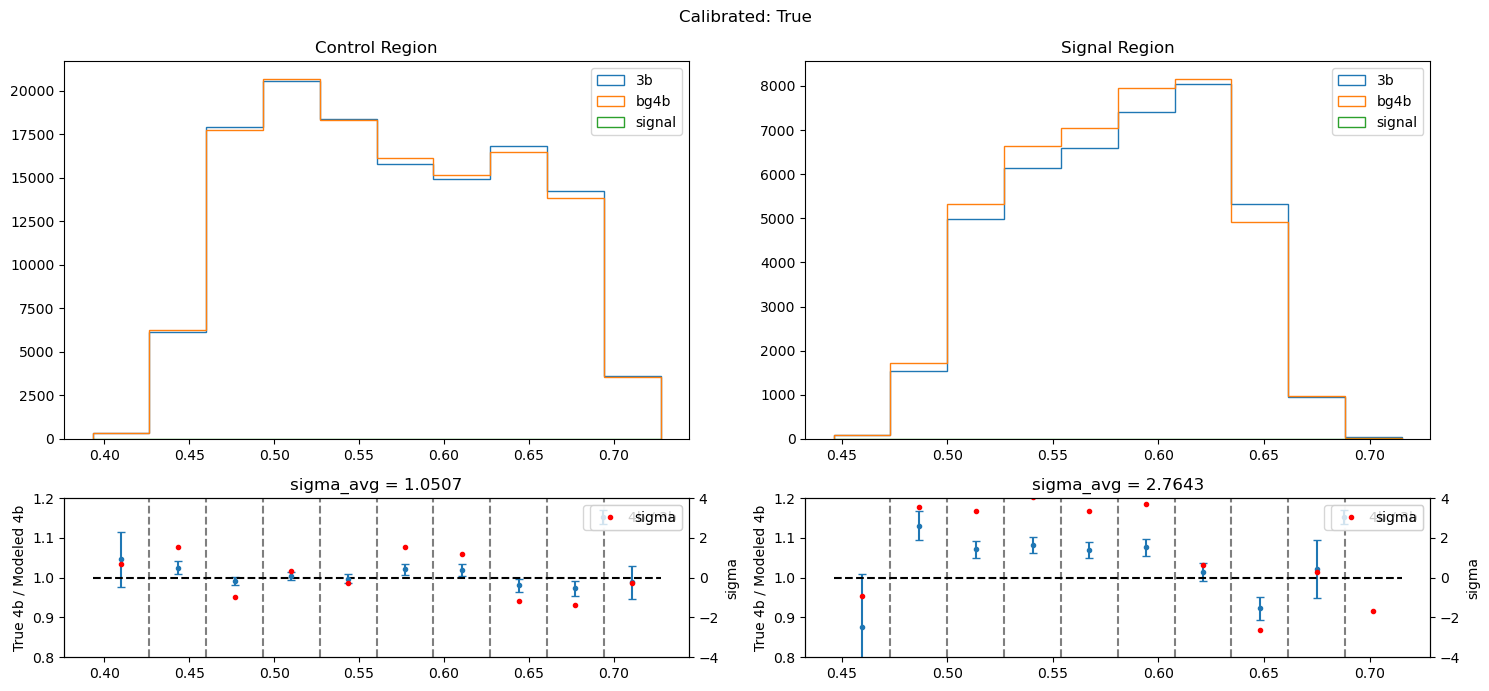

Calibrated: False


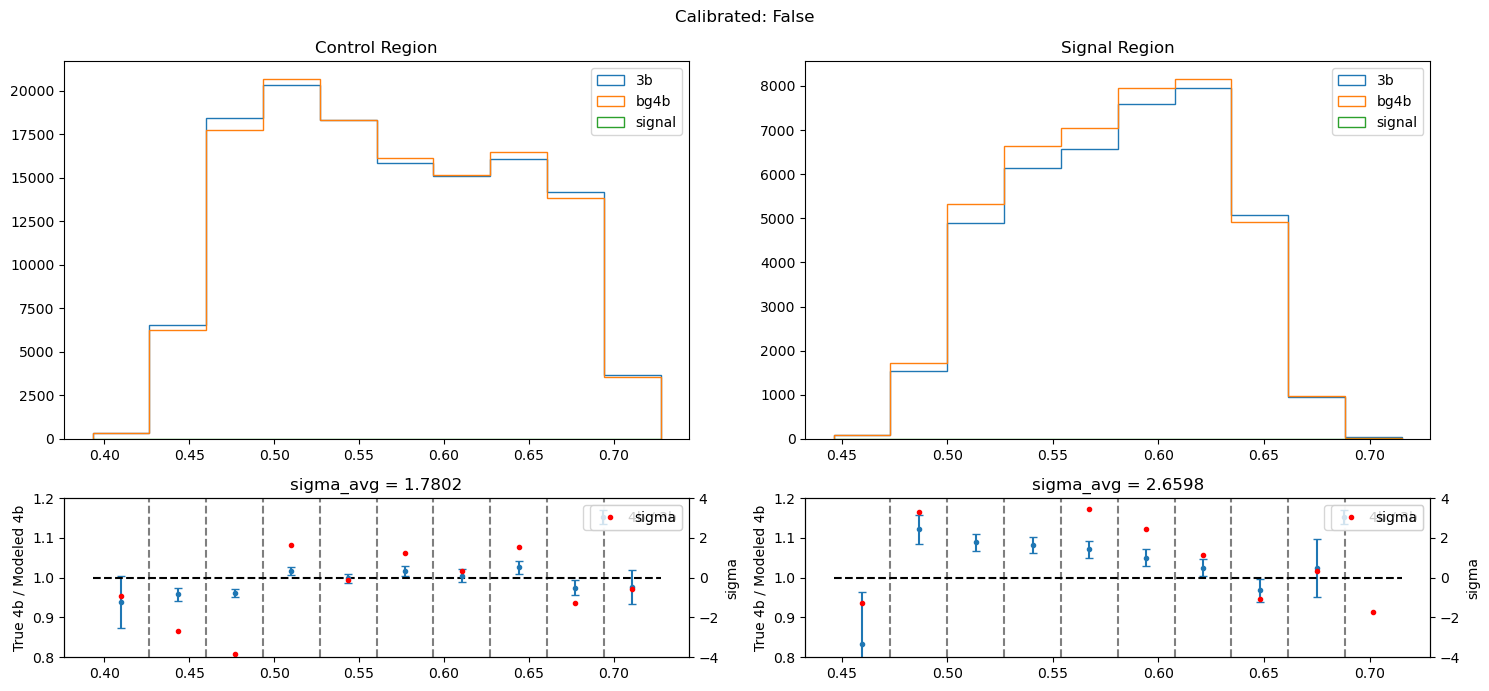

In [36]:
from scipy import stats

nbins = 10
df = nbins
sig_level = 0.05    
print(np.sqrt(stats.chi2.ppf(1 - sig_level, df) / df))

SR_stat_CR = tst_info.SR_stats[in_CR]
SR_stat_SR = tst_info.SR_stats[in_SR]

for calibrated in [True, False]:
    print(f"Calibrated: {calibrated}")
    
    if calibrated:
        probs_CR = probs_CR_isotonic
        probs_SR = probs_SR_isotonic
    else:
        probs_CR = probs_CR_orig
        probs_SR = probs_SR_orig
        
    reweights_CR = probs_CR / (1 - probs_CR) * (ratio_4b / (1 - ratio_4b))
    reweights_SR = probs_SR / (1 - probs_SR) * (ratio_4b / (1 - ratio_4b))
    
    gs = GridSpec(3, 2)
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(f"Calibrated: {calibrated}")
    
    ax = fig.add_subplot(gs[:2, 0])
    ax.set_title(f"Control Region")
    ax2 = fig.add_subplot(gs[2, 0])
    
    events_CR_reweighted = events_CR.clone()

    plot_yeah(ax, ax2, events_CR, events_CR.fvt_score, reweights_CR, nbins, "uniform")
    
    ax = fig.add_subplot(gs[:2, 1])
    ax.set_title(f"Signal Region")
    ax2 = fig.add_subplot(gs[2, 1])
    
    plot_yeah(ax, ax2, events_SR, events_SR.fvt_score, reweights_SR, nbins, "uniform")
    
    plt.tight_layout()
    plt.show()
    plt.close()